# RAGAS Customization
1. 합성 데이터별 시나리오 출력
2. MultihopAbstractQuery 최적화
   * 병렬처리
   * 노드별 이웃 노드 맵 생성
3. 합성 데이터셋 번역 기능
4. 합성 데이터셋 reference_contexts의 index_id 추적

In [1]:
import os
import json
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open('../data/document/역도/chunk_with_overlap.json', 'r', encoding='utf-8') as f:
    origin_data = json.load(f)


total_data = []
for data in origin_data:
    total_data.extend(data)

print(len(total_data))

255


## 지식 그래프 생성

In [3]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType

generator_llm = LangchainLLMWrapper(ChatOpenAI(model='gpt-4o-mini'))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

c:\Users\dbtmd\anaconda3\envs\SportAgent\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_core.documents import Document

kg = KnowledgeGraph()

for doc in total_data:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={'page_content': doc['page_content'],
                        'document_metadata': doc['metadata']}
        )
    )

## 정보 추출 및 관계 형성

In [5]:
from ragas.testset.transforms import apply_transforms
from ragas.testset.transforms.extractors.embeddings import EmbeddingExtractor
from ragas.testset.transforms.extractors.llm_based import (
    SummaryExtractor,
    ThemesExtractor,
    NERExtractor
)
ner_extractor = NERExtractor(llm=generator_llm)
summary_extractor = SummaryExtractor(llm=generator_llm)
themes_extractor = ThemesExtractor(llm=generator_llm)
embedding_extractor = EmbeddingExtractor(
    embedding_model=generator_embeddings,
    property_name="summary_embedding",
    embed_property_name="summary",
    filter_nodes=lambda node: node.get_property("summary") is not None
)

transforms = [
    ner_extractor,
    summary_extractor,
    themes_extractor,
    embedding_extractor
]

# apply_transforms(kg, transforms)

In [6]:
from ragas.testset.transforms.relationship_builders import (
    CosineSimilarityBuilder,
    OverlapScoreBuilder,
)

cosine_sim_builder = CosineSimilarityBuilder(
    property_name="summary_embedding",
    new_property_name="summary_similarity",
    threshold=0.7
)

relation_builder = OverlapScoreBuilder(
    property_name="entities",
    new_property_name="overlap_score",
    threshold=0.01,
    distance_threshold=0.9,
)

transforms = [cosine_sim_builder, relation_builder]
# apply_transforms(kg, transforms)

In [7]:
# kg.save('../data/document/역도/kg.json')
kg = KnowledgeGraph.load('../data/document/역도/kg.json')

## knowledge graph 분석 

### knowledge graph의 nodes 분석
* 분석항목
  * 전체 문서 내 최빈 entity
  * 각 단원(sector)별 최빈 entity
  * 각 단원별 비검출 node 수
* 현황 분석
  * NERExtractor 특징
    * NERExtractor는 일반 entity가 아닌 named entity를 추출함
    * named entity는 고유명사로 특정 이름을 가진 개체로, 주로 사람, 장소, 조직, 날짜/시간 등을 대상으로 함
  * 시사점
    * 최빈 상위 10개 entity 분석 결과, '바벨', '역도', '무릎', '역도선수', '심리기술훈련' 등 사용자 예상 질문과 관성이 적은 entity가 주로 추출
    * 섹터별 상위 entity 분포 결과, 문서 전체에 분포하는 entity가 부재

In [8]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def analyze_node_entity(kg):
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 데이터 구조 초기화
    sector_null = {}
    sector_total = {}
    sector_entities = {}
    total_entities = []
    sectors_order = []
    total_node_count = len(kg.nodes)
    null_node_count = 0

    # 데이터 수집
    for node in kg.nodes:
        sector = node.properties['document_metadata']['heading']['heading1']
        entities = node.properties.get('entities', [])
        if sector not in sectors_order:
            sectors_order.append(sector)
        if sector not in sector_null:
            sector_null[sector] = 0
            sector_total[sector] = 0
            sector_entities[sector] = []
        sector_total[sector] += 1
        if not entities:
            sector_null[sector] += 1
            null_node_count += 1
        else:
            sector_entities[sector].extend(entities)
            total_entities.extend(entities)

    # 전체 entity 없는 노드 비율 계산
    null_ratio = null_node_count / total_node_count * 100

    # 섹터별 entity 없는 노드 비율 계산
    sector_null_ratio = {sector: sector_null[sector] / sector_total[sector] * 100 for sector in sectors_order}

    # 전체 상위 10개 entity
    total_entity_counts = Counter(total_entities)
    top_total_entities = dict(sorted(total_entity_counts.items(), key=lambda x: x[1], reverse=True)[:10])

    # 섹터별 상위 5개 entity
    sector_top_entities = {}
    for sector in sectors_order:
        counts = Counter(sector_entities[sector])
        sector_top_entities[sector] = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5])

    # 시각화
    plt.figure(figsize=(15, 10))

    # 1. 섹터별 entity 없는 노드 비율 막대그래프
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(sector_null_ratio.keys(), sector_null_ratio.values(), color='skyblue')
    plt.ylabel('비율(%)')
    plt.title(f'섹터별 Entity 없는 노드 비율\n(전체 노드 중 entity 없는 노드 비율: {null_ratio:.1f}%)')
    plt.xticks(rotation=45, ha='right')
    # 막대 위에 값 표시
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height:.1f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3pt 위에
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. 전체 상위 10개 entity 막대 그래프
    plt.subplot(2, 2, 2)
    bars2 = plt.bar(top_total_entities.keys(), top_total_entities.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('전체 상위 10개 Entity')
    # 막대 위에 값 표시
    for bar in bars2:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 3. 섹터별 상위 entity 히트맵 (깔끔하게)
    plt.subplot(2, 1, 2)
    sectors = list(sector_top_entities.keys())
    all_entities = sorted({e for ents in sector_top_entities.values() for e in ents})
    heatmap_data = np.zeros((len(sectors), len(all_entities)))
    for i, sector in enumerate(sectors):
        for j, entity in enumerate(all_entities):
            heatmap_data[i, j] = sector_top_entities[sector].get(entity, 0)

    im = plt.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')

    # 컬러바
    cbar = plt.colorbar(im, label='출현 빈도')
    cbar.ax.tick_params(labelsize=10)

    # x, y축 라벨
    plt.xticks(range(len(all_entities)), all_entities, rotation=45, ha='right', fontsize=10)
    plt.yticks(range(len(sectors)), sectors, fontsize=10)
    plt.xlabel('Entity', fontsize=12)
    plt.ylabel('Sector', fontsize=12)
    plt.title('섹터별 상위 Entity 분포', fontsize=14, pad=15)

    # value annotation (0이 아닌 값만)
    for i in range(len(sectors)):
        for j in range(len(all_entities)):
            value = int(heatmap_data[i, j])
            if value > 0:
                plt.text(j, i, str(value), ha='center', va='center', color='black', fontsize=9, fontweight='bold')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # 비율 텍스트로도 출력
    print(f"전체 노드 수: {total_node_count}")
    print(f"Entity가 없는 노드 수: {null_node_count}")
    print(f"전체 노드 중 entity가 없는 노드 비율: {null_ratio:.1f}%")

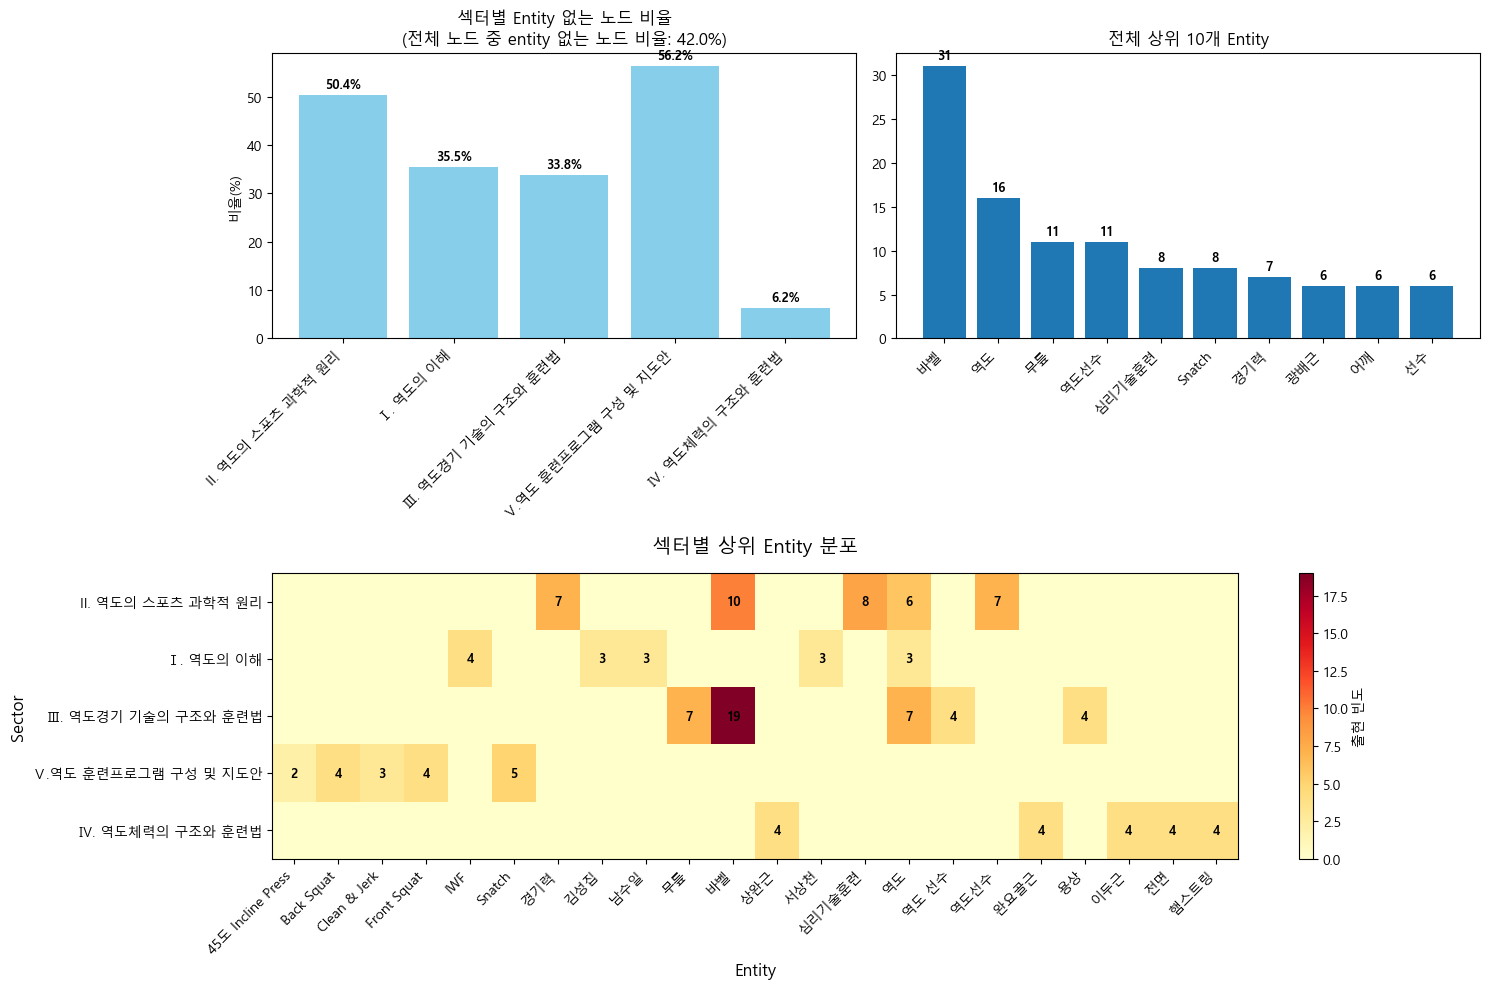

전체 노드 수: 255
Entity가 없는 노드 수: 107
전체 노드 중 entity가 없는 노드 비율: 42.0%


In [9]:
analyzed_result = analyze_node_entity(kg)

### knowledge graph의 relationships 분석
* defualt_transforms의 relationship 형성 과정
  * OverlapScoreBuilder relationship
    * 모든 노드의 entities를 집계 후, 상위 5% entities를 noisy로 활용하여 관계 설정 과정에서 배제
    * 두 노드의 공통된 entity 정도에 따라 relationship 형성 유무 결정    
  * Cosine_Similarity relationship
    * 두 노드의 summary embedding의 cosine similarity에 따라 relationship 형성 유무 결정
* default_transforms의 결과, 타 section 과의 relationship 정도 분석
  * Cosine_Similarity relationship의 타 섹션 관계 비율은 66.6%
  * Overlap relationship의 경우 타 섹션 비율은 37.2%
* 시사점
  * Cosine_Similarity relationship은 타 섹션과의 비율도 높고, 섹터간 적정 network density를 가짐
  * overlap relationship은 운동과 관련된 entity 추출이 아닌 범용적인 name entity 추출 기반 relation 형성 과정
  * 그로 인해 overlap relationship의 수 자체도 매우 적으며, 섹터간 network density와 타 섹션간 비율도 낮음

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def analyze_relationship(kg):
    # 노드 id → 섹션명 매핑
    node_sector = {}
    for node in kg.nodes:
        node_id = node.id.hex
        sector = node.properties['document_metadata']['heading']['heading1']
        node_sector[node_id] = sector

    # 통계 변수 초기화
    rel_types = ['entities_overlap', 'cosine_similarity']
    stats = {rtype: {'total': 0, 'same_sector': 0, 'diff_sector': 0} for rtype in rel_types}
    sector_rel_count = defaultdict(int)  # 섹션별 관계 수

    # 관계 순회하며 통계 집계
    for rel in kg.relationships:
        rel_type = getattr(rel, 'type', rel.__dict__.get('type', ''))
        source_id = rel.__dict__['source'].id.hex
        target_id = rel.__dict__['target'].id.hex
        source_sector = node_sector.get(source_id, 'Unknown')
        target_sector = node_sector.get(target_id, 'Unknown')

        # sector별 관계 수 (source, target 모두 카운트)
        sector_rel_count[source_sector] += 1
        sector_rel_count[target_sector] += 1

        if rel_type not in stats:
            continue

        stats[rel_type]['total'] += 1
        if source_sector == target_sector:
            stats[rel_type]['same_sector'] += 1
        else:
            stats[rel_type]['diff_sector'] += 1

    # 1. OverlapScoreBuilder 그래프
    plt.figure(figsize=(7, 5))
    overlap_same = stats['entities_overlap']['same_sector']
    overlap_diff = stats['entities_overlap']['diff_sector']
    overlap_total = stats['entities_overlap']['total']
    plt.bar(['동일 섹션', '타 섹션'], [overlap_same, overlap_diff], color=['#4F81BD', '#C0504D'])
    for i, v in enumerate([overlap_same, overlap_diff]):
        plt.text(i, v, f'{v} ({v/overlap_total*100:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.title('OverlapScoreBuilder 관계 분포', fontsize=14)
    plt.ylabel('관계 개수')
    plt.tight_layout()
    plt.show()

    # 2. CosineSimilarity 그래프
    plt.figure(figsize=(7, 5))
    cosine_same = stats['cosine_similarity']['same_sector']
    cosine_diff = stats['cosine_similarity']['diff_sector']
    cosine_total = stats['cosine_similarity']['total']
    plt.bar(['동일 섹션', '타 섹션'], [cosine_same, cosine_diff], color=['#4F81BD', '#C0504D'])
    for i, v in enumerate([cosine_same, cosine_diff]):
        plt.text(i, v, f'{v} ({v/cosine_total*100:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.title('CosineSimilarity 관계 분포', fontsize=14)
    plt.ylabel('관계 개수')
    plt.tight_layout()
    plt.show()

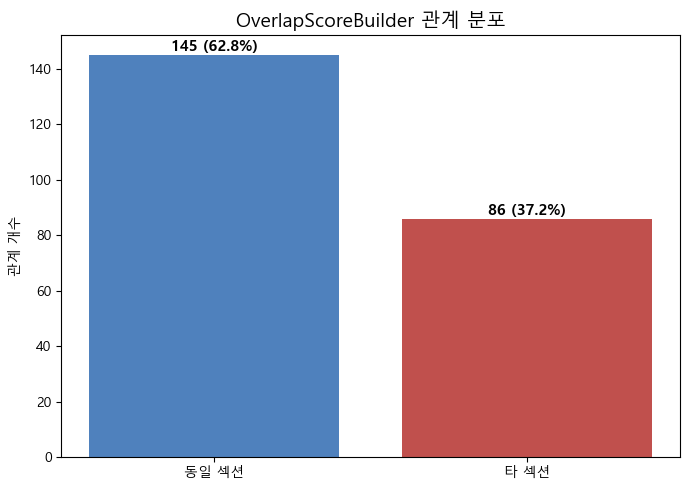

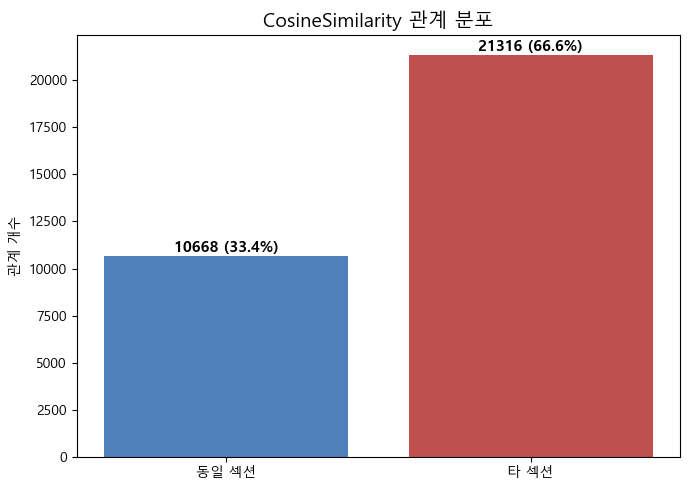

In [11]:
analyze_relationship(kg)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_sector_connection_ratio(kg):
    # 노드 id → 섹터명 매핑 및 섹터별 노드 id 집합
    node_sector = {}
    sector_nodes = defaultdict(set)
    for node in kg.nodes:
        node_id = node.id.hex
        sector = node.properties['document_metadata']['heading']['heading1']
        node_sector[node_id] = sector
        sector_nodes[sector].add(node_id)

    sectors = sorted(sector_nodes.keys())
    n = len(sectors)

    # 실제 관계 수 매트릭스 (source_sector, target_sector)
    actual_matrix_cosine = np.zeros((n, n), dtype=int)
    actual_matrix_overlap = np.zeros((n, n), dtype=int)
    # 가능한 최대 관계 수 매트릭스
    max_matrix = np.zeros((n, n), dtype=int)

    # 관계 집계
    for rel in kg.relationships:
        rel_type = getattr(rel, 'type', rel.__dict__.get('type', ''))
        source_id = rel.__dict__['source'].id.hex
        target_id = rel.__dict__['target'].id.hex
        source_sector = node_sector.get(source_id, 'Unknown')
        target_sector = node_sector.get(target_id, 'Unknown')
        if source_sector in sectors and target_sector in sectors:
            i = sectors.index(source_sector)
            j = sectors.index(target_sector)
            if rel_type == 'cosine_similarity':
                actual_matrix_cosine[i, j] += 1
            elif rel_type == 'entities_overlap':
                actual_matrix_overlap[i, j] += 1

    # 가능한 최대 관계 수 계산
    for i, s1 in enumerate(sectors):
        for j, s2 in enumerate(sectors):
            max_matrix[i, j] = len(sector_nodes[s1]) * len(sector_nodes[s2])

    # 연결 비율(%) 매트릭스
    ratio_matrix_cosine = np.zeros((n, n))
    ratio_matrix_overlap = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if max_matrix[i, j] > 0:
                ratio_matrix_cosine[i, j] = actual_matrix_cosine[i, j] / max_matrix[i, j] * 100
                ratio_matrix_overlap[i, j] = actual_matrix_overlap[i, j] / max_matrix[i, j] * 100

    # DataFrame으로 보기 좋게
    ratio_df_cosine = pd.DataFrame(ratio_matrix_cosine, index=sectors, columns=sectors)
    ratio_df_overlap = pd.DataFrame(ratio_matrix_overlap, index=sectors, columns=sectors)

    # 히트맵 시각화 (2x1 서브플롯)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # cosine_similarity 히트맵
    im1 = ax1.imshow(ratio_matrix_cosine, cmap='YlOrRd', vmin=0, vmax=100)
    plt.colorbar(im1, ax=ax1, label='연결 비율(%)')
    ax1.set_xticks(range(n))
    ax1.set_xticklabels(sectors, rotation=45, ha='right')
    ax1.set_yticks(range(n))
    ax1.set_yticklabels(sectors)
    ax1.set_title('section 간 연결 비율(%) - cosine_similarity 관계')
    for i in range(n):
        for j in range(n):
            ax1.text(j, i, f"{ratio_matrix_cosine[i, j]:.1f}%", ha='center', va='center',
                    color='black' if ratio_matrix_cosine[i, j] < 60 else 'white', fontsize=9, fontweight='bold')

    # entities_overlap 히트맵
    im2 = ax2.imshow(ratio_matrix_overlap, cmap='Blues', vmin=0, vmax=100)
    plt.colorbar(im2, ax=ax2, label='연결 비율(%)')
    ax2.set_xticks(range(n))
    ax2.set_xticklabels(sectors, rotation=45, ha='right')
    ax2.set_yticks(range(n))
    ax2.set_yticklabels(sectors)
    ax2.set_title('section 간 연결 비율(%) - entities_overlap 관계')
    for i in range(n):
        for j in range(n):
            ax2.text(j, i, f"{ratio_matrix_overlap[i, j]:.1f}%", ha='center', va='center',
                    color='black' if ratio_matrix_overlap[i, j] < 60 else 'white', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return ratio_df_cosine, ratio_df_overlap

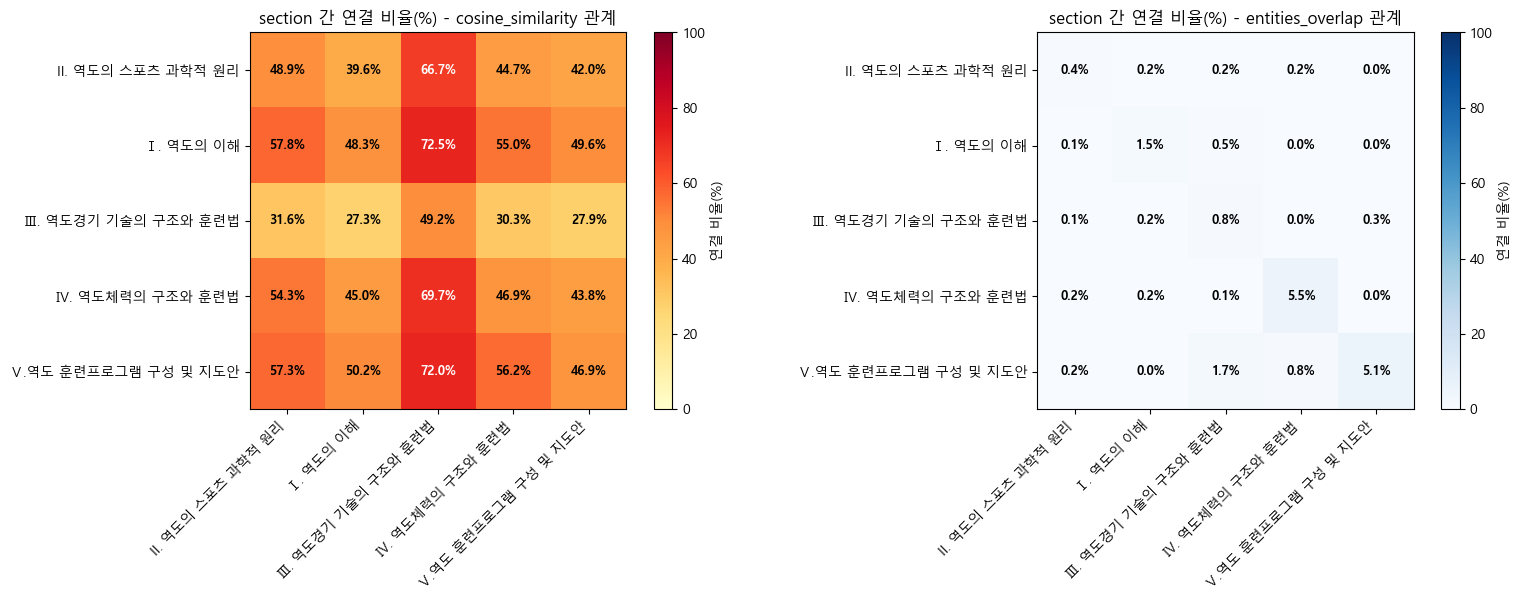

In [15]:
ratio_df = analyze_sector_connection_ratio(kg)

### MultiHopAbstractQuerySunthesizer 최적화

In [8]:
from typing import Dict, List, Tuple, Union
from dataclasses import dataclass, field

import typing as t
import logging
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
from ragas.testset.graph import KnowledgeGraph, Node

from ragas.testset.synthesizers.multi_hop import MultiHopScenario
from ragas.testset.synthesizers.multi_hop.abstract import MultiHopAbstractQuerySynthesizer
from ragas.testset.synthesizers.single_hop.specific import SingleHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.specific import MultiHopSpecificQuerySynthesizer


logger = logging.getLogger(__name__)

@dataclass
class FastMultiHopAbstractQuerySynthesizer(MultiHopAbstractQuerySynthesizer):
    name: str = "fast_multi_hop_abstract_synthesizer"

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._neighbor_cache = {}
        self._cluster_cache = {}
        
    def _build_neighbor_map(self, knowledge_graph: KnowledgeGraph) -> dict:
        """선처리: 노드별 이웃 노드 맵 생성"""
        if not self._neighbor_cache:
            neighbor_map = defaultdict(set)
            # 한 번의 순회로 모든 관계 처리
            for rel in knowledge_graph.relationships:
                if rel.get_property("summary_similarity"):
                    neighbor_map[rel.source].add(rel.target)
            self._neighbor_cache = dict(neighbor_map)
        return self._neighbor_cache

    def _find_cluster_from_node(self, start_node: Node, neighbor_map: dict, max_depth: int = 2) -> set:
        """단일 노드에서 시작하는 클러스터 찾기"""
        # 캐시 확인
        cache_key = (start_node.id, max_depth)
        if cache_key in self._cluster_cache:
            return self._cluster_cache[cache_key]

        visited = {start_node}
        current_level = {start_node}
        
        # BFS 사용 (더 효율적인 메모리 사용)
        for depth in range(max_depth):
            next_level = set()
            for node in current_level:
                neighbors = neighbor_map.get(node, set())
                next_level.update(n for n in neighbors if n not in visited)
            visited.update(next_level)
            current_level = next_level
            if not current_level:  # 더 이상 확장할 노드가 없으면 중단
                break

        # 결과 캐싱
        self._cluster_cache[cache_key] = visited
        return visited

    def get_node_clusters(self, knowledge_graph: KnowledgeGraph) -> t.List[t.Set[Node]]:
        """최적화된 클러스터 찾기"""
        # 1. 이웃 노드 맵 구축 (캐시 활용)
        neighbor_map = self._build_neighbor_map(knowledge_graph)
        
        # 2. 병렬 처리를 위한 함수
        def process_node_chunk(nodes):
            return [self._find_cluster_from_node(node, neighbor_map) for node in nodes]

        # 3. 노드를 청크로 분할하여 병렬 처리
        chunk_size = max(1, len(knowledge_graph.nodes) // (4 * 2))  # CPU 코어 수의 2배 정도의 청크
        node_chunks = [
            list(knowledge_graph.nodes)[i:i + chunk_size]
            for i in range(0, len(knowledge_graph.nodes), chunk_size)
        ]

        # 4. 병렬 처리 실행
        all_clusters = []
        with ThreadPoolExecutor(max_workers=4) as executor:
            chunk_results = list(executor.map(process_node_chunk, node_chunks))
            for chunk_result in chunk_results:
                all_clusters.extend(chunk_result)

        # 5. 중복 제거 및 최소 크기 필터링 (set 연산 사용)
        unique_clusters = set()
        min_cluster_size = 2  # 최소 클러스터 크기 설정
        
        for cluster in all_clusters:
            if len(cluster) >= min_cluster_size:
                frozen_cluster = frozenset(cluster)
                unique_clusters.add(frozen_cluster)

        logger.info(f"Found {len(unique_clusters)} unique clusters")
        return [set(cluster) for cluster in unique_clusters]

### presona 분석
* 생성 페르소나 결과(8개)
  * 스포츠 심리학자: 선수들의 개별적인 니즈와 팀 역학에 맞춘 심리적 기술을 개발하여 효과적인 훈련과 지원을 보장합니다.
  * 스포츠 생리학자: 스포츠에서 근육 활용과 경기력 향상에 중점을 두고 운동 기술을 분석하고 최적화합니다.
  * 한국 스포츠 역사가: 역도 역사와 국가적 자부심에 미친 영향에 초점을 맞춰 한국 선수들의 국제 대회 성과를 연구하고 기록합니다.
  * 근력 트레이닝 코치: 선수들의 역도 기술과 근육 활용을 최적화하는 데 특화되어 있습니다.
  * 스포츠 심리학자: 선수들의 개별적인 특성과 팀 역학을 고려한 맞춤형 심리적 기술 훈련을 통해 경기력 향상을 위해 선수와 협력합니다.
  * 근력 트레이닝 코치: 선수들에게 적절한 리프팅 기술과 근육 활용법을 교육하여 경기력 향상을 도모합니다.
  * 스포츠 심리학자: 선수들의 개별적인 특성과 팀 역학을 고려하여 정신적 기술과 경기력을 향상시킵니다.
  * 스포츠 심리학자: 선수들의 개별적인 니즈와 팀 역학에 맞춘 심리적 기술 훈련을 통해 경기력을 향상시킵니다.
* 시사점
  * generate_personas_from_kg 설명
    * 문서의 summary_embedding 값을 활용하여 cosine_similarities 기반 클러스터링을 생성
    * cosine_similarities가 0.75 이상인 요약을 하나의 요약으로 생성
    * 각 그룹에서 가장 긴 요약을 대표 요약으로 선정
    * 대표 요약을 기반으로 해당 콘텐트와 상호작용하거나 혜택을 받을 가능성이 있는 단일 페르소나를 생성
  * generate_persona_from_kg 결과가 실제 예상 사용자와 큰 차이를 보임

In [9]:
from ragas.testset.persona import generate_personas_from_kg

personas = generate_personas_from_kg(kg=kg, llm=generator_llm, num_personas=8)

Generating personas: 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


### default_distribution 기반의 합성 데이터셋 생성

In [22]:
from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers.single_hop.specific import SingleHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.specific import MultiHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.abstract import MultiHopAbstractQuerySynthesizer


query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
    (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
    (FastMultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25)
]


generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    knowledge_graph=kg,
    persona_list=personas,
)

testset = generator.generate(testset_size=50, query_distribution=query_distribution)
test_df = testset.to_pandas()

Generating Samples: 100%|██████████| 51/51 [00:13<00:00,  3.69it/s]


## 번역

In [30]:
import re
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def classify_language(text):
    english_count = len(re.findall(r'[a-zA-Z]', text))
    korean_count = len(re.findall(r'[가-힣]', text))

    if english_count >= korean_count:
        return 'english'

    return 'korean'


def translate(testset_df):
    template = """
        You are an expert translator specializing in English to Korean translation.

        Translate the following English text into natural Korean.  
        Only output the translated Korean text.  
        If a term is a proper noun or a commonly used English term (e.g., "clean and jerk"), transliterate it into Korean and include the original English in parentheses.

        Text:  
        {input_text}
    """ 

    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    prompt = PromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    testset_df['language_user_input'] = testset_df['user_input'].apply(lambda x : classify_language(x))
    testset_df['language_reference'] = testset_df['reference'].apply(lambda x : classify_language(x))

    user_data = testset_df.loc[(testset_df['language_user_input'] == 'english'), 'user_input'].tolist()
    reference_data = testset_df.loc[(testset_df['language_reference'] == 'english'), 'reference'].tolist()

    translate_user = chain.batch(user_data, config={'max_concurrency': 5})
    translate_reference = chain.batch(reference_data, config={'max_concurrency': 5})

    testset_df.loc[(testset_df['language_user_input'] == 'english'), 'user_input'] = translate_user
    testset_df.loc[(testset_df['language_reference'] == 'english'), 'reference'] = translate_reference

    return testset_df.iloc[:, :4]

In [31]:
trans_df = translate(test_df)

## 합성 데이터셋 생성
* Multi-Hop Specific의 타 섹션간 결합 데이터의 비율 낮음
* 예상 사용자의 질의와 관련성이 낮은 데이터 비율이 높음

In [ ]:
import re 

def make_chunk_dict(knowledge_graph):
    chunk_dict = {}
    chunk_id_dict = {}
    chunk_summary_embedding = {}
    for node in kg.nodes:
        section = node.properties['document_metadata']['heading']['heading1']
        chunk_id = node.properties['document_metadata']['chunk_id']
        summary_embedding = node.properties['summary_embedding']
        page_content = node.properties['page_content']

        chunk_dict[page_content] = section
        chunk_id_dict[page_content] = chunk_id
        chunk_summary_embedding[page_content] = summary_embedding
    return chunk_dict, chunk_id_dict, chunk_summary_embedding

def regular_expression(reference_contexts, chunk_dict):
    if len(reference_contexts) == 1:
        return [chunk_dict[reference_contexts[0]]]
    else:
        return [chunk_dict[re.sub(r"<\d+-hop>\n\n", "", text)] for text in reference_contexts] 
    
    
def analyze_synthetic_data(kg, testset_df):
    chunk_dict = make_chunk_dict(kg)
    testset_df['reference_contexts_section'] = testset_df['reference_contexts'].apply(lambda x : regular_expression(x, chunk_dict))
    testset_df = testset_df.drop(columns = ['language_user_input', 'language_reference'])

    return testset_df

result = analyze_synthetic_data(kg, test_df)

In [41]:
result.head(2)

,user_input,reference_contexts,reference,synthesizer_name,language_user_input,language_reference,reference_contexts_section
0,역도 슈즈는 어떤 역할을 하나요?,"[3) 벨트의 최대 넓이는 12cm를 넘지 말아야 한다. 4) 붕대, 반창고 혹은 ...","역도 슈즈는 역도 선수들이 발에 신는 신발로, 선수들이 무릎에 붕대를 감고 있는 모...",single_hop_specifc_query_synthesizer,korean,korean,[Ⅰ. 역도의 이해]
1,"역도(context of weightlifting)에서, 엉덩이 관절(hip joi...","[인상동작과 시작자세 → 끌기(first pull)자세 → 몸통 펴기(잡아채기, s...","역도에서, 엉덩이 관절에서 바벨의 수직 축까지의 거리가 60cm이고 바벨의 무게가 ...",single_hop_specifc_query_synthesizer,english,english,[II. 역도의 스포츠 과학적 원리]
2,파워 클린의 훈련 계획은 무엇인가요?,"[초급자는 일주일에 3번 훈련하는 것이 바람직하며, 기록의 향상보다는 기술의 완\n...","초급자를 위한 훈련 계획에서 1일차에는 '파워 클린', '스내치', '백 스쿼트' ...",single_hop_specifc_query_synthesizer,korean,korean,[Ⅴ.역도 훈련프로그램 구성 및 지도안]
3,전술적 위기 막기 위해 뭐 해야 해?,"[시합에서 발생하는 심리적, 전술적 위기를 막기 위해 심리적 위기를 유발하는\n심리...","전술적 위기를 막기 위해 심리적 위기를 유발하는 심리기술을 관리해야 하며, 이를 위...",single_hop_specifc_query_synthesizer,korean,korean,[II. 역도의 스포츠 과학적 원리]
4,역도 훈련에서 Top Snatch는 어떻게 진행되나요?,[이미지는 역도 경기의 Top Snatch 훈련 방법을 단계별로 보여준다. 첫 번째...,역도 훈련에서 Top Snatch는 단계별로 진행됩니다. 첫 번째 단계에서는 역도 ...,single_hop_specifc_query_synthesizer,korean,korean,[Ⅲ. 역도경기 기술의 구조와 훈련법]
5,바벨을 들어 올릴 때 가장 중요한 근육은 무엇인가요?,[이미지는 '라스트 풀 동작 수행의 한국과 중국의 비교'를 보여주고 있다. 한국과 ...,"바벨을 들어 올릴 때 가장 강하게 근력을 발휘할 수 있는 근육은 하지 신전근들이며,...",single_hop_specifc_query_synthesizer,korean,korean,[II. 역도의 스포츠 과학적 원리]
6,근력 훈련이 운동선수의 수행능력 향상에 어떻게 기여하는지 설명해 주세요.,[근력은 1회 최대한의 힘을 발휘하여 동원된 힘의 총합을 의미한다. 근력 향상은\n...,"근력 훈련은 근육뿐만 아니라 뼈, 건, 인대도 강화시키는 효과가 있으며, 이는 선수...",single_hop_specifc_query_synthesizer,korean,korean,[II. 역도의 스포츠 과학적 원리]
7,스쿼트는 역도선수 훈련에서 어떤 역할을 해?,"[역도선수는 기술훈련을 하는 동안 근 손상과 상\n해를 예방하기 위해서 계획적이며,...","스쿼트는 역도선수들이 훈련할 때 자유스러운 부하로 벤치 프레스, 스쿼트와 데드 리프...",single_hop_specifc_query_synthesizer,korean,korean,[II. 역도의 스포츠 과학적 원리]
8,체조에서 경기력에 영향을 미치는 주요 요인은 무엇인가요?,"[경기력에 관련된 체육학계의 관점은 경기력을 구성하는 체력, 기술 , 심리, 전술\...",체조에서는 선수의 경기력 수준이 높아질수록 체력보다는 기술이 경기력을 결정하는 영향...,single_hop_specifc_query_synthesizer,korean,korean,[II. 역도의 스포츠 과학적 원리]
9,2003년경에 실시된 연구에서 축구 선수의 성과에 영향을 미치는 심리적 요인은 무엇...,"[한편, 축구경기력 결정 심리요인의 위계적 중요도를 중심으로 한 연구(윤영\n길, ...",2003년경에 실시된 연구에서 축구 선수의 성과에 영향을 미치는 심리적 요인으로는 ...,single_hop_specifc_query_synthesizer,english,english,[II. 역도의 스포츠 과학적 원리]


# RAGAS 실험
### 평가 항목
1. Generation 
   1. Faithfulness
      * 주어진 문맥에 대한 생성된 답변의 사실적 일관성 측정
      * 답변과 검색된 문맥(retrieved context)를 기준으로 계산
      * (0, 1) 범위 스케일이며, 값이 높을수록 좋음
      * 생성된 답변이 신뢰할 수 있다고(faithful) 간구되려면 답변에서 제시된 모든 주장이 주어진 문맥(given context)에서 추론될 수 있어야 함
      * 생성된 답변에서 주장의 집합(claims)를 식별 -> 각 주장마다 주어진 맥락 기반 여부 확인
      * 점수: context 기반의 답변 내 주장 수 / 전체 주장 수
      * 예시
        * 아이슈타인의 출생일자와 출생지는 어디인가?
          * 답변 1: 아이슈타인은 독엘에서 1879/3/14에 태어났습니다.
            * 
          * 답변 2: 아이슈타인은 독엘에서 1879/4/14에 태어났습니다.
            * 
          * context: 
* 
   1. 
1. Retriever
   1. 